### K-Means Clustering for Amazon food reviews:

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
#getting cleaned data from db
conn = sqlite3.connect('final_clean_LR.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [3]:
#SORT by time for TBS
final_review = final_review.sort_values(by='Time')

In [ ]:
final_review.drop('Score',axis=1,inplace=True)

In [4]:
#info of data
final_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 23 to 345187
Data columns (total 15 columns):
level_0                   364171 non-null int64
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
CleanedTextBow            364171 non-null object
final_text                364171 non-null object
final_stem_text           364171 non-null object
dtypes: int64(6), object(9)
memory usage: 44.5+ MB


In [5]:
#Converting to int8
final_review.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
final_review.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [6]:
train_df = final_review.iloc[:round(final_review.shape[0]*0.70),:]
test_df = final_review.iloc[round(final_review.shape[0]*0.70):,:]

#### Bag of Words

In [7]:
#BoW with cleaned data and without stopwords
#simple cv for train data
scores_train = []
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
#X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = count_vect.fit_transform(
        train_df['final_text'].values)
final_counts_test = count_vect.transform(
        test_df['final_text'].values)

In [11]:
ssd = {}
centers = {}
for k in range(1,31):
    model = KMeans(n_clusters=k,n_init=10,max_iter=800,random_state=25,n_jobs=-1)
    model.fit(final_counts_train)
    ssd[k] = model.inertia_
    centers[k] = model.cluster_centers_
    print('No of clusters',k,'Sum of Squared dist',model.inertia_)

No of clusters 2 Sum of Squared dist 17090972.935039584
No of clusters 3 Sum of Squared dist 16889129.80389441
No of clusters 4 Sum of Squared dist 16599901.618375564
No of clusters 5 Sum of Squared dist 16662864.771436755
No of clusters 6 Sum of Squared dist 16384658.648390105
No of clusters 7 Sum of Squared dist 16298392.490236422
No of clusters 8 Sum of Squared dist 16205244.435071379
No of clusters 9 Sum of Squared dist 16110676.756141247
No of clusters 10 Sum of Squared dist 16014505.905228948
No of clusters 11 Sum of Squared dist 15988800.120337114
No of clusters 12 Sum of Squared dist 15934268.485165115
No of clusters 13 Sum of Squared dist 15899301.555551339
No of clusters 14 Sum of Squared dist 15880090.2596671
No of clusters 15 Sum of Squared dist 15867199.892136786
No of clusters 16 Sum of Squared dist 15826427.815612264
No of clusters 17 Sum of Squared dist 15764300.773115376
No of clusters 18 Sum of Squared dist 15722229.345665809
No of clusters 19 Sum of Squared dist 1571

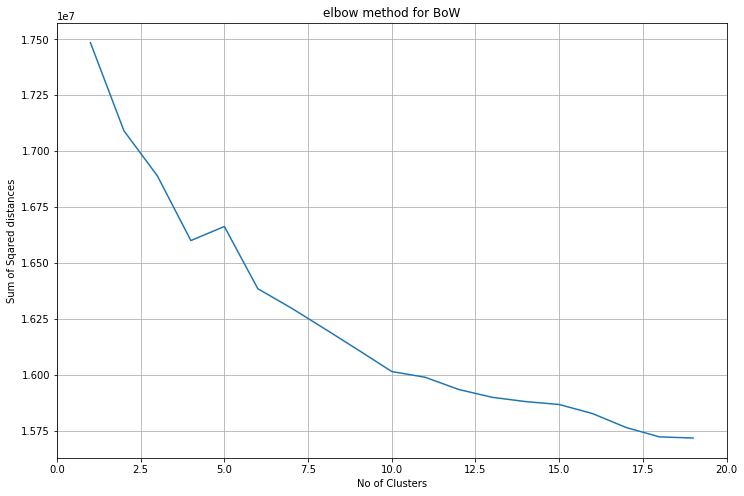

In [229]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,20)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method for BoW')
plt.grid()

from above we can observe that 10 cluster are good 

In [9]:
model_bow = KMeans(n_clusters=10,n_init=10,random_state=25)
model_bow.fit(final_counts_train)

In [233]:
#labes for all the data in train_df
model_bow.labels_

array([0, 0, 0, ..., 0, 0, 2], dtype=int32)

In [234]:
train_df['bow_pred_label'] = model_bow.labels_

In [235]:
#no of points in each group
train_df.groupby('bow_pred_label')['final_text','ProductId'].count()

,final_text,ProductId
bow_pred_label,,
0,142764,142764
1,9029,9029
2,14666,14666
3,2027,2027
4,22661,22661
5,5917,5917
6,3289,3289
7,10456,10456
8,1222,1222


In [236]:
grp = train_df.groupby('bow_pred_label')[['final_text','ProductId']]

In [131]:
print('group 0')
for i in grp.get_group(0).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 0
great product bad price but why would pay amazon twice what they charge brick and mortar store
B000NN5GU8

this awesome this better than peanut butter hand down it only got one ingredient and thats organic sunflower seed would recommend this everyone
B002OK2FCA

little guy these are perfect for little guy they are the perfect size for him and love that they are juice
B003GBHX5K

awesome popcorn have been ordering this popcorn from bob red mill for several year and great able order from amazon now after this popcorn which light and clean other popcorn can measure use the Orville reddenbock microwave popper and make great bowl popcorn small large and with without the oil the four pack last long time and the long run much le expensive than the bag popcorn
B004VLV6ES

too good there huge problem with these cracker cant limit myself cant describe the taste except say addictive not cracker lover these are the first cracker have bought second time now get them auto delivery they are l

In [132]:
print('group 1')
for i in grp.get_group(1).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 1
great dog food great price and very good food for our dog her coat shiny bad breath and she love the taste
B0009X63VS

great price great ingredient searched the dog food rating page and found this one the best for it price dog are both healthy they eat just like they any food have year old female golden retriever year old female labrador retriever
B0018CE6DQ

great treat dog loved this treat wouldnt recommend for large dog mine lb and she finished about hour liked the fact that didnt get slimy smelly maybe there wasnt enough time for that
B000RI40UQ

aggressive chewer semi satisfied saying month lab puppy aggressive chewer understatement she truly put all toy through the ringer and will put others given the opportunity that being said have only owned this toy for day and she ha gotten very small smaller than rice sized off the souper sized bone the product did say that this would happen wa prepared and only give this her while are home she ha mean broken and are hopeful that th

In [134]:
print('group 2')
for i in grp.get_group(2).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 2
alkaline tea for all who have acid reflux Gerd great tasting alkaline decaf tea which should used everybody that suffers from acid reflux Gerd use one bag and make pot Cuisinart coffee pot get off the coffee and caffeine kick and get well
B000CMIZ0I

garbage purchased the december and returned back bus wholesale club the have very little coffee inside them you want large cup cup coffee forget the size small and the coffee watered down same thing with the size you want espresso buy something under keurig screwed with this line called customer service one pick the phone and you can not leave message either final for more information
B003WAX3H2

awesome flavor love this coffee the morning noon night doe not have too much coconut flavor but just enough would absolutely recommend this coffee
B003G52BN0

disappointing you may wondering what disappointing about four star coffee this better than average brew reasonably strong while not bitter robust bean but the flavour intense not par

In [138]:
print('group 3')
for i in grp.get_group(3).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 3
great coffee decided try this coffee whim since the town college town that ha very limited coffee selection else the coffee overpriced when saw this saw two thing hawaiian blend and hazelnut immediately wanted try bought and brewed some soon could and really really like this coffee this coffee seems have the perfect balance between the coffee taste and the flavor which awesome because many time flavored coffee taste just like regular coffee blend the only thing that did not like wa the fact that the bag are not resealable
B003OP558A

Dumm bought this local grocery store use new coffee espresso machine big coffee nut even roast own coffee have grinder but the moment it about mile away from had settle with this and honest it pretty tasty much better than Starbucks best freshly ground stuff tell you how bad really worst coffee the universe but compared own stuff illy coffee downright nasty yes freshly roasted freshly ground coffee that good but you have nothing else available you 

In [144]:
print('group 4')
for i in grp.get_group(4).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 4
work expected after month chasing two dog out the garden and ruining few plant ordered the from amazon realized when arrived forgot order the ground rod luckily wa cheaper the local home store for footer and cut half suit need the charger worked exactly expected tested the only guaranteed way know and wow see why the dog dont like didnt hurt all but wa startling now back gardening
B000HHO9EE

soft and yummy wa hesitant give these try because they are expensive but after reading the ingredient list the price wa reasonable because almond paste expensive these are very sweet but they are also nice and soft the inside and crunchy the outside you get fair amount cooky the bag these are great for those who are gluten free eater and those who are not hoping try few other flavor soon
B004GYFK9M

magic indeed the aroma upon opening the lentil wa intense and appealing wa expecting one spice drown out the others but wa symphony flavor
B0043OU7LG

rare treat from the black sesame porridge 

In [148]:
print('group 5')
for i in grp.get_group(5).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 5
were these review written dale corporate short and girlfriend sent bottle for christmas she life alabama live maine not health nut and love good steak sauce this not the stuff taste like kinsman steroid salty that couldnt deal with the bottle say avg serving ha salt sodium that more than half the daily allowance for someone with heart problem cholesterol Jadda Jadda this stuff heart attack bottle also ha bunch msg not concerned because think the msg scare bunch hoopla from the moonrat lefty crowd youre moonrat type advised main complaint wa the flavor said taste just like soy sauce not first choice flavor good steak would strongly recommend steak sauce worcestershire sauce over this stuff any day also McCormick ha some excellent marinade that come dry envelope just add oil sorry dump this stuff but being honest and objective can here
B001EO5YR0

nice treat but substitute moderate drinker both soda and juice wa intrigued the promise the switch would receive the vitamin benefit j

In [150]:
print('group 6')
for i in grp.get_group(6).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 6
 not normally one for writing review since normally other people cover own concern praise their own however one the big reason switched cat this food wa that wa fiance and both have celiac and the wheat that present lot other food wa making sick have had issue handling this food and cat love lick finger the cat love the food you should see how excited they get the morning when open the bin their fur incredibly soft they are energetic and doesnt make sick
B001BOVE54

the worst part cat day now the best have struggled for over year and half giving cat daily pill she foam and vomit easily and she and both dread this daily torture have tried bury the pill every treat and delicious food could think including raw liver but soon she smelled the pill which ha disgusting bitter taste the vet say she wouldnt try anything but this week tried the pill pocket and cat just about stood head get out hand she could eat she go absolutely nut for and doesnt detect her pill all the worst part cat 

In [151]:
print('group 7')
for i in grp.get_group(7).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 7
deliciously cool this second purchase this tea this year and love ha such crisp clean cool taste and fantastic aroma can drink pitcher cold day also delicious hot hot cup totally relaxes right before bedtime wa disappointed see amazon eliminating most the numb loose tea favor bag most the numb loose tea they have kept are now being sold lot instead time thats with because drink much long they not discontinue favorite this one the ginger sprite with black oolong and the ruby chai herbal messan fantastic stuff
B001ELLB20

great tea this wonderful smooth and flavorful tea love this stuff and when serve guest they rave about well keep mind that the peach and apricot only provide hint flavor you are looking for strong fruit flavor this not your tea have been pleased with all the Davidson tea that have tried but this one really favorite this not tea but excellent tea this price
B000SATIKK

real cup tea this the only decaf tea the dozen have tried that make real cup tea strong with ta

In [153]:
print('group 8')
for i in grp.get_group(8).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 8
fine camomile tea lazos calm herbal infusion nice chamomile tea taste the chamomile and some flavoring and they are not unpleasant just hard pin down what they are besides the chamomile general not big fan tea with flavoring added preferring the subtleness and authentic taste the real thing the ingredient calm chamomile flower hibiscus flower spearmint lemongrass rose petal blackberry leaf safflower peppermint sarsaparilla lemon balm licorice and natural flavor Gazo interesting company that make only super premium tea they are socially responsible based portland and have the motto the reincarnation tea Gazo owned Starbucks their web site fun and quirky with focus definitely worth checking out unclear though from their web site how many their ingredient are organic kosher and they use some natural flavor their wording seems little vague for super premium tea the paper tea packet Gazo writes soothing blend chamomile blossom and other relaxing herb their web site Gazo describes th

In [241]:
print('group 9')
for i in grp.get_group(9).sample(5).values:
    print(i[0])
    print(i[1])
    print()

group 9
great buy husband diabetic and this ha carbs which are sugar not too bad for snack have many problem controlling his blood sugar but this mixture seems agree with him doe not raise his number perfect and tasty treat they dont skimp the berry walnut very good value emerald nut tropical blend bag pack
B001M08XS8

not recommended the manufacturer but work anyway although sugar floss not recommended for use the nostalgia electric hard candy sugar free cotton candy machine didnt find out until both were already purchased tried using anyway and you let the machine heat well before using will make delicious amusement park style cotton candy used one teaspoon time the sugar will last year but yummy
B000UYICMO

quality product thats surpassed expectation chose this product because it shipped quickly wonderful company and the product top notch addition wanted protein powder thats free all the junk fat excessive calorie creatine and stimulant aside from basic whey protein contains laundry

0 - Some Miscellaneous food products and reviews size are small   
1 - Dog food related produtc  
2 - coffee related products with small reviws  
3- Coffe related produts with high reviews  
4 - Some coffe related products with differnt flovers  
5 - related to drinks and soups  
6 -  some animal foods  
7 - about tea  
8 - about tea with large reviews  
9 - Miscellaneous food products with some good reviews  

### Tf-Idf

In [12]:
#TFIDF with (1,2) gram with cleaned data 
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_counts_train = tf_idf_vect.fit_transform(
        train_df['final_text'].values)

In [13]:
for i in range(1,100):
    model = KMeans(n_clusters=i,n_init=50,max_iter=300,random_state=25,n_jobs=-1)
    model.fit(final_counts_train)
    ssd[i] = model.inertia_
    centers[i] = model.cluster_centers_
    labels = model.labels_
    print('No of clusters',i,'Sum of Squared dist',model.inertia_)

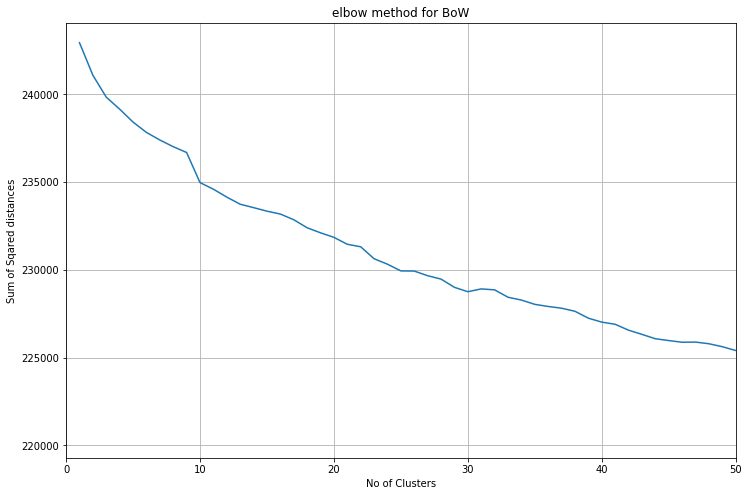

In [16]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,50)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method for BoW')
plt.grid()

after 10 clusters squared distances is decreasing by very less rate than before 10. so 10 may be better choice of clusters.

In [27]:
model = KMeans(n_clusters=10,n_init=10,max_iter=300,random_state=25,n_jobs=-1)
model.fit(final_counts_train)

In [28]:
model.labels_

array([2, 2, 2, ..., 9, 9, 0], dtype=int32)

In [30]:
train_df['tfidf_pred_label'] = model.labels_

In [32]:
#no of points in each group
train_df.groupby('tfidf_pred_label')['final_text','ProductId'].count()

,final_text,ProductId
tfidf_pred_label,,
0,18315,18315
1,16372,16372
2,85268,85268
3,3611,3611
4,7254,7254
5,18734,18734
6,4713,4713
7,59518,59518
8,2300,2300


In [34]:
grp = train_df.groupby('tfidf_pred_label')[['final_text','ProductId']]

In [65]:
for i in range(10):
    print('group ',i)
    for i in grp.get_group(i).sample(5).values:
        print(i[0])
        print(i[1])
        print()

group  0
great cup coffee this coffee really good have been drinking for our morning for the last year husband say ha never had better when have quest and serve this coffee they all agree with him have amazon subscription have delivered monthly our door dont run out thanks amazon for offering this great product
B0001ES9FI

perfect for aeropress this coffee the best ive found far and love that it organic wa using major Dickson from meet coffee but this le expensive and organic and just good maybe even better got use with the aerobic aeropress coffee and espresso maker and it perfect wa going give boyfriend sample convince him switch from meet but wa afraid running out pound lot coffee but apparently through more than two pound coffee month should mention that only make coffee with the aeropress and they say that coffee made that way smoother while have compared this coffee other coffee made the same way dont know how itd say drip coffee maker
B000KSTY86

yum crave this coffee didnt expe

0 - coffe  
1- tea  
2 - some seed like produts but overlap is there  
3- soups
4- bread cakes  
5 -dog related  
6 - some cereal produts  
7 -  misc produts  
8 - pasta and noodle based   
9 -candys and some junk food  

#### Word2Vec

In [10]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [11]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [89]:
#word2vec model with 50 dim vector
w2v_model_50=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=8)
#word2vec model with 100 dim vector
w2v_model_100=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=8)
#word2vec model with 300 dim vector
w2v_model_300=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=8)

In [12]:
#loading from disk
w2v_model_100 = pickle.load(open('w2v_model_dt_100.p','rb'))
w2v_model_50 = pickle.load(open('w2v_model_dt_50.p','rb'))
w2v_model_300 = pickle.load(open('w2v_model_dt_300.p','rb'))

#### Avg Word2Vec

In [13]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model,d):
    '''
    Returns average of word vectors for 
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [14]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())

In [15]:
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)

In [125]:
train_df_avgw2v_300.to_csv('train_df_avgw2v_300_km.csv')

In [18]:
ssd = {}
centers = {}
s = []
for i in range(1,25):
    model = KMeans(n_clusters=i,n_init=10,max_iter=300)
    model.fit(train_df_avgw2v_300)   
    ssd[i] = model.inertia_
    centers[i] = model.cluster_centers_
    print('No of clusters',i,'Sum of Squared dist',model.inertia_)

No of clusters 1 Sum of Squared dist 21478458.5677
No of clusters 2 Sum of Squared dist 13151425.9848
No of clusters 3 Sum of Squared dist 9763301.69767
No of clusters 4 Sum of Squared dist 8287436.51602
No of clusters 5 Sum of Squared dist 6996673.5982
No of clusters 6 Sum of Squared dist 6249683.64389
No of clusters 7 Sum of Squared dist 5827920.66685
No of clusters 8 Sum of Squared dist 5528591.41371
No of clusters 9 Sum of Squared dist 5267355.5692
No of clusters 10 Sum of Squared dist 5083635.81328
No of clusters 11 Sum of Squared dist 4860846.33753
No of clusters 12 Sum of Squared dist 4685988.30479
No of clusters 13 Sum of Squared dist 4566925.31898
No of clusters 14 Sum of Squared dist 4473099.36642
No of clusters 15 Sum of Squared dist 4363387.89202
No of clusters 16 Sum of Squared dist 4288240.38983
No of clusters 17 Sum of Squared dist 4203399.91147
No of clusters 18 Sum of Squared dist 4130410.6869
No of clusters 19 Sum of Squared dist 4079661.38805
No of clusters 20 Sum of

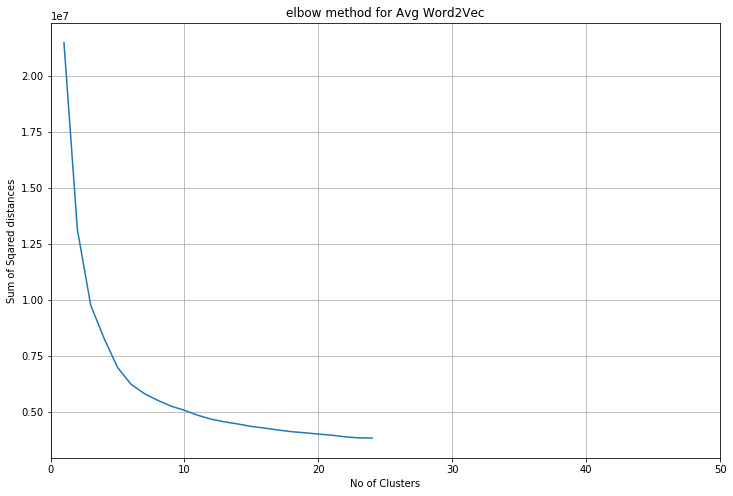

In [19]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,50)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method for Avg Word2Vec')
plt.grid()

In [103]:
model = KMeans(n_clusters=8,n_init=10,max_iter=300)
model.fit(train_df_avgw2v_300)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [109]:
model.labels_

array([6, 0, 6, ..., 6, 6, 6], dtype=int32)

In [110]:
train_df['avgw2v_label'] = model.labels_

In [111]:
#no of points in each group
train_df.groupby('avgw2v_label')['final_text','ProductId'].count()

,final_text,ProductId
avgw2v_label,,
0,66829,66829
1,2043,2043
2,25081,25081
3,75,75
4,227,227
5,6721,6721
6,153289,153289
7,655,655


In [112]:
grp = train_df.groupby('avgw2v_label')[['final_text','ProductId']]

In [132]:
for i in range(8):
    print('group ',i)
    for i in grp.get_group(i).sample(5).values:
        print(i[0])
        print(i[1])
        print()

group  0
this too expensive this cost the super market why going pay almost for one can this product
B00510NMKO

atomic fire ball not sure why but order came and most the fireball are soft and few are harder prefer the harder one and wonder the softer one are stale fresh
B003U4Q0E8

super ordered the pop tart and they came within week really nice have this option available thanks
B000M2UNI0

good for the money must admit after realized this wa foreign honey did feel bit guilty for ordering mix few different country used local honey doe have bit different taste just taste extra that make sense whoever reading this with that being said job find supply for office the best price possible and very much met that goal with this product this wa the best price could find anywhere and looked for day there wa like difference some online store the shipping wa little slow get but everyone seems happy for the most part with the taste being concentrated le used the product last longer all all with le

There is so much overlap in many groups and not able to divide by product types. because of Word similarity avg vectors some reviews are overlapping. some of them i find  
0 - Misc products but maximum contains good ratings  
1- Candies chocolates  
2 - oil/seed related  
3- Misc products so much overlap but maximum contains bad ratings  
4- Coffe/tea related  
5 - max dog related   

#### Tf-Idf Weighted Word2Vec

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class TfidfWeightedWord2Vec(BaseEstimator, TransformerMixin):
    '''
    Class for Tfidf Weighted Word2Vec Calculations
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = word2vec.vector_size
        self.tfidf = None

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer()
        tfidf.fit(X[:,0])
        self.tfidf = tfidf
        #print(self.word2vec.wv.vocab.keys())
        return self
    
    def tf_idf_W2V(self,feature_names,tf_idf_trans_arr,list_of_sent):
        '''
        tfidf weighted word2vec calculation
        '''
        import operator
        dict_tfidf = {k: v for v, k in enumerate(feature_names)}
        sent_vectors = []
        i = 0
        for sent in list_of_sent: # for each review/sentence
            doc = [word for word in sent if word in self.word2vec.wv.vocab.keys()]
            if doc:
                #itemgetter
                f = operator.itemgetter(*doc)
                try:
                    #itemgetter from dict
                    final = f(dict_tfidf)
                    final = tf_idf_trans_arr[i,final]
                    #converting to dense
                    final = final.toarray()
                    #converting to diagnol matrix for multiplication
                    final= np.diag(final[0])
                    sent_vec = np.dot(final,np.array(self.word2vec.wv[doc]))
                    #tfidf weighted word to vec
                    sent_vec = np.sum(sent_vec,axis=0) / np.sum(final)
                except:
                    sent_vec = np.zeros(self.dim)             
            else:
                sent_vec = np.zeros(self.dim)
            sent_vectors.append(sent_vec)
            i = i+1
        return sent_vectors

    def transform(self, X):
        #transform data
        tf_idf_trans_arr = self.tfidf.transform(X[:,0])
        feature_names = self.tfidf.get_feature_names()
        list_of_sent = []
        for sent in X[:,0]:
            list_of_sent.append(sent.split())
        temp_vec = self.tf_idf_W2V(feature_names,tf_idf_trans_arr,list_of_sent)
        temp_vec= np.hstack((temp_vec,X[:,[1,2]]))
        return temp_vec

In [15]:
# For simple cv
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(train_df[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train = tfidfvect_w2v.transform(train_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)

In [140]:
ssd = {}
centers = {}
s = []
for i in range(1,30):
    model = KMeans(n_clusters=i,n_init=10,max_iter=300)
    model.fit(X_train)   
    ssd[i] = model.inertia_
    centers[i] = model.cluster_centers_
    print('No of clusters',i,'Sum of Squared dist',model.inertia_)

No of clusters 1 Sum of Squared dist 24171833.5224
No of clusters 2 Sum of Squared dist 15844570.7006
No of clusters 3 Sum of Squared dist 12456011.6976
No of clusters 4 Sum of Squared dist 10979501.604
No of clusters 5 Sum of Squared dist 9679840.63928
No of clusters 6 Sum of Squared dist 8944502.93965
No of clusters 7 Sum of Squared dist 8487686.19372
No of clusters 8 Sum of Squared dist 8071787.08606
No of clusters 9 Sum of Squared dist 7804478.04089
No of clusters 10 Sum of Squared dist 7482311.49733
No of clusters 11 Sum of Squared dist 7219493.00424
No of clusters 12 Sum of Squared dist 7071082.9754
No of clusters 13 Sum of Squared dist 6827409.11229
No of clusters 14 Sum of Squared dist 6715620.45991
No of clusters 15 Sum of Squared dist 6573033.69893
No of clusters 16 Sum of Squared dist 6466839.46489
No of clusters 17 Sum of Squared dist 6356654.12795
No of clusters 18 Sum of Squared dist 6247787.95109
No of clusters 19 Sum of Squared dist 6166076.20957
No of clusters 20 Sum o

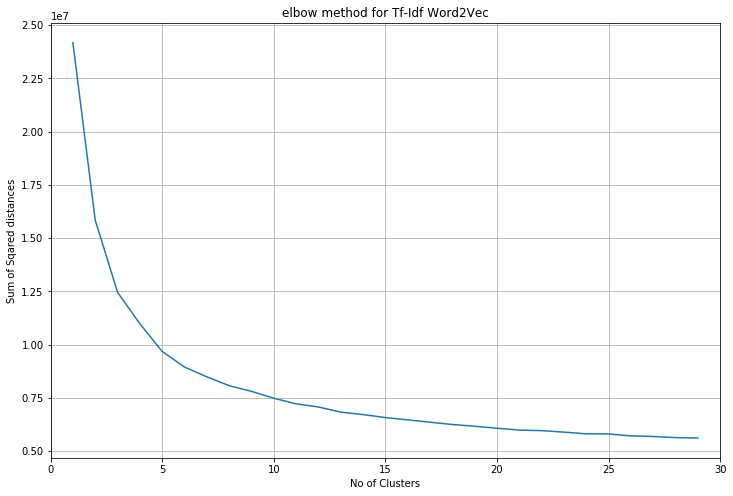

In [142]:
plt.figure(figsize=(12,8))
plt.plot(list(ssd.keys()),list(ssd.values()))
plt.xlim(0,30)
plt.xlabel('No of Clusters')
plt.ylabel('Sum of Sqared distances')
plt.title('elbow method for Tf-Idf Word2Vec')
plt.grid()

from elbow metod we can find after 10 decrease is less so optimal may be 10.

In [109]:
model = KMeans(n_clusters=10,n_init=10,max_iter=300)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [110]:
train_df['tfidfw2v_pred_label'] = model.labels_

In [111]:
 #no of points in each group
train_df.groupby('tfidfw2v_pred_label')['final_text','ProductId'].count()

,final_text,ProductId
tfidfw2v_pred_label,,
0,24524,24524
1,74134,74134
2,2142,2142
3,6315,6315
4,742,742
5,42445,42445
6,17689,17689
7,76,76
8,86578,86578


In [112]:
grp = train_df.groupby('tfidfw2v_pred_label')[['final_text','ProductId']]

In [113]:
for i in range(10):
    print('group ',i)
    for i in grp.get_group(i).sample(5).values:
        print(i[0])
        print(i[1])
        print()

group  0
delightful tea think this the best jasmine tea ever full jasmine flower and fragrance and not bitter not habitual tea drinker except for this particular tea
B000NIHZMU

instant coffee hope you are reading these review did not this instant coffee inside container the description deceptive
B006N3I69A

kahlua mocha coffee review wonderful tasting and wonderful smell the kahlua mocha coffee also make the best tasting frappucinos ever complemented with splenia mocha flavor stick ive not been able find this brand local store and wa dreadful find amazon other coffee ha compared this for iced coffee drink
B002TIR3BU

tea good addictive dont single day without drinking least one cup revolution sweet ginger peach love loose leaf tea and find that most tea bag are really inferior you can taste the dry dusty poor quality the cup but loose leaf tea can hard make time for hectic workday morning when traveling etc these tea bag solve the problem the silky bag contain loose leaf tea finally a

Not find any tyoe of groups by product type and upto 3 clusters the sum of sqared distance drop is very high so tried with 3 and got some results as below

In [56]:
model = KMeans(n_clusters=3,n_init=10,max_iter=300)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [57]:
model.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [58]:
train_df['tfidfw2v_pred_label'] = model.labels_

In [59]:
train_df.tfidfw2v_pred_label.value_counts()

1    231946
0     21462
2      1512
Name: tfidfw2v_pred_label, dtype: int64

In [50]:
train_df['Score'] = train_df['Score'].apply(lambda x : 0 if x == 'positive' else 1)

In [60]:
train_df.Score.value_counts()

0    216889
1     38031
Name: Score, dtype: int64

In [61]:
#no of points in each group
train_df.groupby('tfidfw2v_pred_label')['final_text','ProductId'].count()

,final_text,ProductId
tfidfw2v_pred_label,,
0,21462,21462
1,231946,231946
2,1512,1512


In [88]:
acc = 0
pos = 0
for idx,row in train_df.iterrows():
    c = row['tfidfw2v_pred_label']
    if c == 1:
        c = 0
    elif c == 0:
        c = 1
    if row['Score'] == c:
        acc = acc + 1
        if c == 0:
            pos = pos + 1

In [89]:
accuracy = acc/len(train_df)
accuracy

0.8151851561274125

In [90]:
tpr = pos/sum(train_df.Score==0)
tpr

0.92610044769444277

###### Bag of Word representation:
there is overlap but i can find maximum of them as below categories. 
0 - Some Miscellaneous food products and reviews size are small  
1 - Dog food related produtc 
2 - coffee related products with small reviws  
3- Coffe related produts with high reviews  
4 - Some coffe related products with differnt flovers  
5 - related to drinks and soups  
6 - some animal foods  
7 - about tea  
8 - about tea with large reviews  
9 - Miscellaneous food products with some good reviews  
###### Tf-Idf representation:
0 - coffe related  
1- tea related  
2 - some seed like produts but overlap is there  
3- soups 4- bread cakes  
5 -dog related  
6 - some cereal produts    
7 - misc produts  
8 - pasta and noodle based  
9 -candys and some junk food  
###### avg Word2Vec:
There is so much overlap in many groups and not able to divide by product types. because of Word similarity avg vectors some reviews are overlapping. some of them i find
0 - Misc products but maximum contains good ratings  
1- Candies chocolates  
2 - oil/seed related  
3- Misc products so much overlap but maximum contains bad ratings  
4- Coffe/tea related  
5 - max dog related  
###### Tf-Idf Weighted Word2vec:
i find there is so much overlap in the clusters and tried with 3 clusters, and checked for positive and negative samples in those clusters and got accuracy of 82% and true positive rate of 92%.